In [32]:
import glob, os, sys, re, random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from Bio import SeqIO
import tqdm

In [33]:
def collect_seqs(pattern: str, label: str, genes: list, sp=False, aa=False):
    directory = "/home/gabs/Documents/lab/TermitesAndCockroaches/MIDORI/"
    file = "MIDORI2_{}_NUC_SP_GB261_{}_BLAST.fasta" if sp else "MIDORI2_{}_NUC_GB261_{}_BLAST.fasta"
    if aa:
        file = "MIDORI2_{}_AA_SP_GB261_{}_BLAST.fasta" if sp else "MIDORI2_{}_AA_GB261_{}_BLAST.fasta"
    path_to_fasta = directory + file
    seqs = defaultdict(list)
    for gene in tqdm.tqdm(genes):
        inp = path_to_fasta.format(label, gene)
        for rec in SeqIO.parse(inp, "fasta"):
            header = rec.description
            
            if pattern not in header:
                continue

            raw_acc, taxa = header.split("###")
            acc, place = re.match("(\w+\.\d)\.(.+)", raw_acc).groups()
            taxa = taxa.removeprefix("root_1;Eukaryota_2759;")
            species = " ".join(taxa.split(";")[-1].split("_")[:-1])
            rec.id = acc
            rec.description = f"{species} {place} ###{taxa}"
            seqs[gene + "__" + species.replace(" ", "_")].append(rec)
    return seqs


def filter_seqs(recs: list, var_gene_len=0.2, Nshare=0.2):
    assert isinstance(recs, list)
    seq_len_median = np.median([len(x) for x in recs])
    min_seq_len = seq_len_median * (1 - var_gene_len)
    max_seq_len = seq_len_median * (1 + var_gene_len)

    recs_filtered = []
    for rec in recs:
        acgt_share = sum(rec.seq.count(x) for x in "ACGT") / len(rec)
        if min_seq_len < len(rec) < max_seq_len and 1 - acgt_share < Nshare:
            recs_filtered.append(rec)

    return recs_filtered


def filter_seqs_dict(seqs, nseqs_min=10, var_gene_len=0.2, Nshare=0.2):
    assert isinstance(seqs, dict)
    seqs_filtered = dict()
    for gene_species, recs in seqs.items():
        if len(recs) < nseqs_min:
            continue

        recs_filtered = filter_seqs(recs, var_gene_len, Nshare)
        if len(recs_filtered) >= nseqs_min:
            seqs_filtered[gene_species] = recs_filtered
    
    return seqs_filtered

In [34]:
genes = ['A6', 'A8', 'CO1', 'CO2', 'CO3', 'Cytb', 'ND1', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6']
genes = ['CO1']
order = "Blattodea"
nucls_blat = collect_seqs(order, "UNIQ", genes)
len(nucls_blat)

100%|██████████| 1/1 [00:07<00:00,  7.90s/it]


1026

In [35]:
nucls_blat_filtered = filter_seqs_dict(nucls_blat, nseqs_min=5)
print(f"nseqs = {len(nucls_blat_filtered)}, nspecies: {len(set([x.split('__')[1] for x in nucls_blat_filtered.keys()]))}", end="\n\n")
print(pd.Series(Counter([x.split("__")[0] for x in nucls_blat_filtered.keys()])))

nseqs = 142, nspecies: 142

CO1    142
dtype: int64


In [36]:
seq_lens = []
for sp, recs in nucls_blat_filtered.items():
    seq_len_median = np.median([len(x) for x in recs])
    nucls_blat_filtered[sp].append(seq_len_median)
    seq_lens.append(seq_len_median)

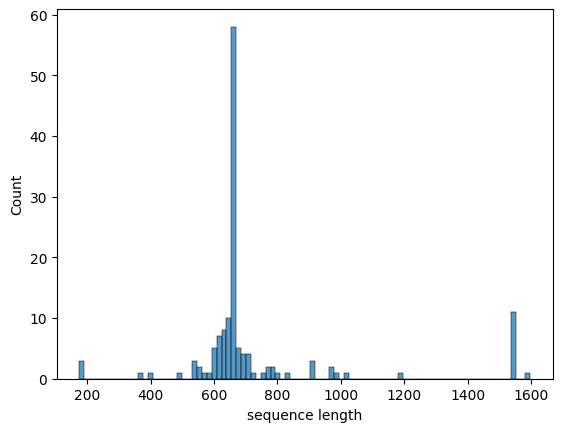

In [37]:
ax = sns.histplot(seq_lens)
ax.set(xlabel='sequence length')
plt.show()

In [38]:
sp_to_remove = []
for sp, recs in nucls_blat_filtered.items():
    seq_len_median = recs[-1]
    if seq_len_median < 600 or seq_len_median > 800:
        sp_to_remove.append(sp)

In [39]:
for sp in sp_to_remove:
    del nucls_blat_filtered[sp]

In [40]:
len(nucls_blat_filtered)


106

In [41]:
seq_lens = []
for sp, recs in nucls_blat_filtered.items():
    seq_lens.append(recs[-1])

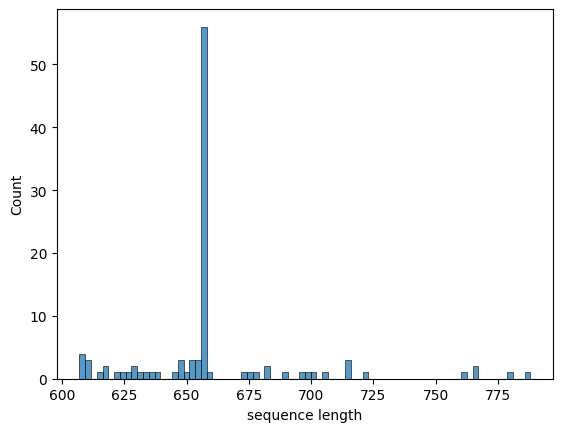

In [42]:
ax = sns.histplot(seq_lens)
ax.set(xlabel='sequence length')
plt.show()

In [43]:
prots_blat = collect_seqs(order, "UNIQ", genes, aa=True)

100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


In [44]:
prots_filtered = {}
for sp, recs in prots_blat.items():
    if sp in nucls_blat_filtered.keys():
        seqs = [rec.seq for rec in recs]
        lens = [len(seq) for seq in seqs]
        median_len = np.median(lens)

        close_to_median = min(seqs, key=lambda seq: abs(len(seq) - median_len))
        taxonomy = prots_blat[sp][0].name.split("###root_1;Eukaryota_2759;Arthropoda_6656;")[1]
        prots_filtered[f'{sp.split("__")[1]} --- {taxonomy}'] = close_to_median

In [51]:
lens = []
for seq in prots_blat['CO1__Eupolyphaga_robusta']:
    lens.append(len(seq.seq))
    print(f'{len(seq.seq)} --- {seq.seq}')

212 --- AWAGMVGTSLSMLIRAELGQPGSLIGDDQIYNVIVTAHAFVMIFFMVMPILIGGFGNWLVPLMLGAPDMAFPRMNNMSFWLLPPSLSFLLASSMIESGVGTGWTVYPPLASNIAHAGASVDLAIFSLHLAGVSSILGAVNFISTTINMKPINMKPEQIPLFVWAVVITALLLLLSLPVLAGAITMLLTDRNLNTSFFDPAGGGDPILYQHLF
219 --- TLYFIFGAWAGMVGTSLSMLIRAELGQPGSLIGDDQIYNVIVTAHAFVMIFFMVMPILIGGFGNWLVPLMLGAPDMAFPRMNNMSFWLLPPSLSFLLASSMIESGVGTGWTVYPPLASNIAHAGASVDLAIFSLHLAGVSSILGAVNFISTTINMKPINMKPEQIPLFVWAVVITALLLLLSLPVLAGAITMLLTDRNLNTSFFDPAGGGDPILYQHLF


In [52]:
lens

[212, 219]

In [48]:
prots_filtered

{'Blaptica_dubia --- Insecta_50557;Blattodea_85823;Blaberidae_6979;Blaptica_132934;Blaptica_dubia_132935': Seq('KYKDIGTLYFIFGAWAGMVGTSLSMLIRVELNQPGSLIGDDQIYNVIVTAHAFI...HLE'),
 'Hemiblabera_pabulator --- Insecta_50557;Blattodea_85823;Blaberidae_6979;Hemiblabera_2587879;Hemiblabera_pabulator_2587880': Seq('GAWAGMVGTSLSMLIRAELNQPGSLIGDDQIYNVIVTAHAFIMIFFMVMPILIG...GGG'),
 'Diploptera_maculata --- Insecta_50557;Blattodea_85823;Blaberidae_6979;Diploptera_6983;Diploptera_maculata_2163988': Seq('TLYFIFGAWAGMVGTSLSMLIRAELNQPGSLIGDDQIYNVIVTAHAFVMIFFMV...HLF'),
 'Diploptera_punctata --- Insecta_50557;Blattodea_85823;Blaberidae_6979;Diploptera_6983;Diploptera_punctata_6984': Seq('HPEVYILILPGFGMISHIICHESGKKEAFGNLGMIFAMLAIGLLGFVVWAHHMF...ELP'),
 'Brephallus_fruhstorferi --- Insecta_50557;Blattodea_85823;Blaberidae_6979;Brephallus_2421530;Brephallus_fruhstorferi_2421531': Seq('TLYFIFGAWAGMVGTSLSMLIRAELNQPGSLIGDDQIYNVIVTAHAFIMIFFMV...HLF'),
 'Opisthoplatia_orientalis --- Insecta_50557;Blattodea_85823

In [49]:
fams = set()
for sp in prots_filtered.keys():
    fam = sp.split(';')[2]
    fams.add(fam)
fams

{'Anaplectidae_2163898',
 'Blaberidae_6979',
 'Blattellidae_3046527',
 'Blattidae_6974',
 'Corydiidae_30007',
 'Cryptocercidae_36982',
 'Ectobiidae_1049651',
 'Hodotermitidae_70920',
 'Kalotermitidae_46562',
 'Nocticolidae_85826',
 'Pseudophyllodromiidae_3046452',
 'Rhinotermitidae_36985',
 'Termitidae_46569',
 'Termopsidae_7501'}

In [60]:
ter_fams = ['Hodotermitidae_70920', 'Kalotermitidae_46562', 'Rhinotermitidae_36985', 'Termitidae_46569', 'Termopsidae_7501']

taxonomy_all = []

for sp, seq in prots_filtered.items():
    fam = sp.split(';')[2]
    sp_name = sp.split(' --- ')[0]
    taxonomy = reversed(re.sub(r'_[0-9]+', '', sp).split(";")[1:])
    taxonomy = ";".join(taxonomy) + ";Insecta"
    taxonomy_all.append(taxonomy)

    if fam in ter_fams:
        with open(f"/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/new_midori_sep_ids/termite/{sp_name}_CO1.fasta", "w") as fout:
            fout.write(f">{sp}\n{seq}")
    else:
        with open(f"/mnt/data/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/NemuPipeline/TermAndCock/new_midori_sep_ids/non-termite/{sp_name}_CO1.fasta", "w") as fout:
            fout.write(f">{sp}\n{seq}")

with open('/home/gabs/Documents/lab/TermitesAndCockroaches/mtdna-mutspec-insecta/data/MIDORI/new_blattodea_CO1.tax', 'w') as fout:
    for entry in taxonomy_all:
        fout.write(f'{entry}\n')


In [58]:
for sp in prots_filtered.keys():
    taxonomy = reversed(re.sub(r'_[0-9]+', '', sp).split(";")[1:])
    taxonomy = ";".join(taxonomy) + ";Insecta"
    break